In [1]:
import torch
import torch.utils.data 
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fix random seed

In [3]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Cuda/MPS

In [4]:
use_cuda_if_available = True

# Dataloader

In [5]:
### Define the custom PyTorch dataloader for this assignment
class dataloader(torch.utils.data.Dataset):
    """Loads the KITTI Odometry Benchmark Dataset"""
    def __init__(self, matfile, binsize=45, mode='train'):
        self.data = sio.loadmat(matfile)
        
        self.images = self.data['images']
        self.mode = mode

        # Fill in this function if you wish to normalize the input
        # Data to zero mean.
        self.normalize_to_zero_mean()
        
        if self.mode != 'test':

            # Generate targets for images by 'digitizing' each azimuth 
            # angle into the appropriate bin (from 0 to num_bins)
            self.azimuth = self.data['azimuth']
            bin_edges = np.arange(-180,180+1,binsize)
            self.targets = (np.digitize(self.azimuth,bin_edges) -1).reshape((-1))

    def normalize_to_zero_mean(self):
        # Calculate the mean for each channel
        mean = np.mean(self.images, axis=(0, 1, 2))
        self.images = self.images - mean

    def __len__(self):
        return int(self.images.shape[0])
  
    def __getitem__(self, idx):
        if self.mode != 'test':
            return self.images[idx], self.targets[idx]    
        else:
            return self.images[idx]

In [6]:
binsize=45 #degrees **set this to 20 for part 2**
bin_edges = np.arange(-180,180+1,binsize)
num_bins = bin_edges.shape[0] - 1
dsets = {x: dataloader('sun-cnn_{}.mat'.format(x),binsize=binsize) for x in ['train', 'val']} 
dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=64, shuffle=True, num_workers=0) for x in ['train', 'val']}
print("finish loading data")
loss = {'train': [], 'val': []}
top1err = {'train': [], 'val': []}
top5err = {'train': [], 'val': []}
best_err = 1

finish loading data


# CNN Class

In [7]:
class CNN(torch.nn.Module):
    def __init__(self, num_bins): 
        super(CNN, self).__init__()

        # Define the layers directly within the class
        self.network = torch.nn.Sequential(
            # First Convolutional Block
            torch.nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=3),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            
            # Second Convolutional Block
            torch.nn.Conv2d(32, 64, kernel_size=3, padding=2),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Third Convolutional Block
            torch.nn.Conv2d(64, 128, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(128),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Fourth Convolutional Block
            torch.nn.Conv2d(128, 256, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(256),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),

            torch.nn.Conv2d(256, 256, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(256),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),

            # Flatten the output for the fully connected layers
            torch.nn.Flatten(),

            # Fully Connected Layers
            torch.nn.Linear(768, 1024),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(1024, num_bins)
        )

        if use_cuda_if_available and torch.cuda.is_available():
            self = self.cuda()

    ###Define what the forward pass through the network is
    def forward(self, x):
        x = self.network(x)
        x = x.squeeze() # (Batch_size x num_bins x 1 x 1) to (Batch_size x num_bins)

        return x

# Train

## Network Initialization

In [8]:
cnn = CNN(num_bins) #Initialize our CNN Class
CE_loss = torch.nn.CrossEntropyLoss(reduction='sum') #initialize our loss (specifying that the output as a sum of all sample losses)
params = list(cnn.parameters())
optimizer = torch.optim.Adam(params, lr=0.001, weight_decay=0.000001, amsgrad=True)

## Training Loop

In [9]:
for epoch in tqdm(range(0,20)):
    for mode in ['train', 'val']:    #iterate 
        epoch_loss=0
        top1_incorrect = 0
        top5_incorrect = 0
        if mode == 'train':
            cnn.train(True)    # Set model to training mode
        else:
            cnn.train(False)    # Set model to Evaluation mode
            cnn.eval()
        
        dset_size = dset_loaders[mode].dataset.__len__()
        for image, target in dset_loaders[mode]:    #Iterate through all data (each iteration loads a minibatch)
            # Cast to types and Load GPU if desired and available
            if use_cuda_if_available and torch.cuda.is_available():
                image = image.cuda().type(torch.cuda.FloatTensor)
                target = target.cuda().type(torch.cuda.LongTensor)
            else:
                image = image.type(torch.FloatTensor)
                target = target.type(torch.LongTensor)
            optimizer.zero_grad()    #zero the gradients of the cnn weights prior to backprop
            pred = cnn(image)   # Forward pass through the network
            minibatch_loss = CE_loss(pred, target)  #Compute the minibatch loss
            epoch_loss += minibatch_loss.item() #Add minibatch loss to the epoch loss 
            
            if mode == 'train': #only backprop through training loss and not validation loss       
                minibatch_loss.backward()
                optimizer.step()        
                    
            
            _, predicted = torch.max(pred.data, 1) #from the network output, get the class prediction
            top1_incorrect += (predicted != target).sum().item() #compute the Top 1 error rate
            
            top5_val, top5_idx = torch.topk(pred.data,5,dim=1)
            top5_incorrect += ((top5_idx != target.view((-1,1))).sum(dim=1) == 5).sum().item() #compute the top5 error rate

        loss[mode].append(epoch_loss/dset_size)
        top1err[mode].append(top1_incorrect/dset_size)
        top5err[mode].append(top5_incorrect/dset_size)

        print("{} Loss: {}".format(mode, loss[mode][epoch]))
        print("{} Top 1 Error: {}".format(mode, top1err[mode][epoch]))    
        print("{} Top 5 Error: {}".format(mode, top5err[mode][epoch])) 
        if mode == 'val':
            print("Completed Epoch {}".format(epoch))
            if top1err['val'][epoch] < best_err:
                best_err = top1err['val'][epoch]
                best_epoch = epoch
                torch.save(cnn.state_dict(), 'best_model_{}.pth'.format(binsize))
print("Training Complete")
print("Lowest validation set error of {} at epoch {}".format(np.round(best_err,2), best_epoch))        

  0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.4111999561227868
train Top 1 Error: 0.13660148719361057
train Top 5 Error: 0.017901404571743322


  5%|▌         | 1/20 [00:10<03:22, 10.65s/it]

val Loss: 1.9040119916620388
val Top 1 Error: 0.38028169014084506
val Top 5 Error: 0.176056338028169
Completed Epoch 0
train Loss: 0.09014686599837556
train Top 1 Error: 0.03167171578077665
train Top 5 Error: 0.0


 10%|█         | 2/20 [00:13<01:49,  6.07s/it]

val Loss: 1.4625661393286478
val Top 1 Error: 0.3647887323943662
val Top 5 Error: 0.0323943661971831
Completed Epoch 1
train Loss: 0.09792243068587908
train Top 1 Error: 0.032497934453318646
train Top 5 Error: 0.0002754062241806665


 15%|█▌        | 3/20 [00:16<01:17,  4.53s/it]

val Loss: 0.9512575777483658
val Top 1 Error: 0.2943661971830986
val Top 5 Error: 0.007042253521126761
Completed Epoch 2
train Loss: 0.06830920195307032
train Top 1 Error: 0.020104654365188653
train Top 5 Error: 0.0


 20%|██        | 4/20 [00:18<01:00,  3.80s/it]

val Loss: 3.083203963158836
val Top 1 Error: 0.46056338028169014
val Top 5 Error: 0.07746478873239436
Completed Epoch 3
train Loss: 0.03588672642088468
train Top 1 Error: 0.011567061415587993
train Top 5 Error: 0.0


 25%|██▌       | 5/20 [00:21<00:50,  3.39s/it]

val Loss: 1.0101375237317152
val Top 1 Error: 0.2619718309859155
val Top 5 Error: 0.016901408450704224
Completed Epoch 4
train Loss: 0.05746165548711071
train Top 1 Error: 0.014596529881575324
train Top 5 Error: 0.0002754062241806665


 30%|███       | 6/20 [00:24<00:44,  3.15s/it]

val Loss: 0.7759408930657615
val Top 1 Error: 0.2084507042253521
val Top 5 Error: 0.0014084507042253522
Completed Epoch 5
train Loss: 0.022704119548607845
train Top 1 Error: 0.006058936931974662
train Top 5 Error: 0.0


 35%|███▌      | 7/20 [00:26<00:38,  2.97s/it]

val Loss: 1.534007075135137
val Top 1 Error: 0.3154929577464789
val Top 5 Error: 0.04647887323943662
Completed Epoch 6
train Loss: 0.014318157647126175
train Top 1 Error: 0.004131093362709997
train Top 5 Error: 0.0


 40%|████      | 8/20 [00:29<00:34,  2.85s/it]

val Loss: 1.2929981120875185
val Top 1 Error: 0.2915492957746479
val Top 5 Error: 0.02676056338028169
Completed Epoch 7
train Loss: 0.012099058150960924
train Top 1 Error: 0.0033048746901679976
train Top 5 Error: 0.0


 45%|████▌     | 9/20 [00:32<00:30,  2.79s/it]

val Loss: 1.1121463453265983
val Top 1 Error: 0.2647887323943662
val Top 5 Error: 0.014084507042253521
Completed Epoch 8
train Loss: 0.0030270520300422037
train Top 1 Error: 0.0008262186725419994
train Top 5 Error: 0.0


 50%|█████     | 10/20 [00:34<00:27,  2.73s/it]

val Loss: 1.870006418899751
val Top 1 Error: 0.36338028169014086
val Top 5 Error: 0.023943661971830985
Completed Epoch 9
train Loss: 0.0019555010645478732
train Top 1 Error: 0.0008262186725419994
train Top 5 Error: 0.0


 55%|█████▌    | 11/20 [00:37<00:24,  2.76s/it]

val Loss: 1.3185761209944604
val Top 1 Error: 0.30140845070422534
val Top 5 Error: 0.01971830985915493
Completed Epoch 10
train Loss: 0.007846768269599042
train Top 1 Error: 0.002203249793445332
train Top 5 Error: 0.0


 60%|██████    | 12/20 [00:40<00:22,  2.79s/it]

val Loss: 2.561999259196537
val Top 1 Error: 0.4014084507042254
val Top 5 Error: 0.022535211267605635
Completed Epoch 11
train Loss: 0.011778803285251337
train Top 1 Error: 0.003029468465987331
train Top 5 Error: 0.0


 65%|██████▌   | 13/20 [00:43<00:20,  2.86s/it]

val Loss: 1.790290135397038
val Top 1 Error: 0.3816901408450704
val Top 5 Error: 0.035211267605633804
Completed Epoch 12
train Loss: 0.023093869074506064
train Top 1 Error: 0.00468190581107133
train Top 5 Error: 0.0


 70%|███████   | 14/20 [00:46<00:16,  2.81s/it]

val Loss: 2.0997705862555707
val Top 1 Error: 0.3929577464788732
val Top 5 Error: 0.02676056338028169
Completed Epoch 13
train Loss: 0.033897022816476434
train Top 1 Error: 0.007435968052877995
train Top 5 Error: 0.0


 75%|███████▌  | 15/20 [00:48<00:13,  2.76s/it]

val Loss: 1.2527918600700272
val Top 1 Error: 0.3267605633802817
val Top 5 Error: 0.011267605633802818
Completed Epoch 14
train Loss: 0.020977032433705894
train Top 1 Error: 0.004406499586890664
train Top 5 Error: 0.0


 80%|████████  | 16/20 [00:51<00:10,  2.74s/it]

val Loss: 1.3282465706408864
val Top 1 Error: 0.29014084507042254
val Top 5 Error: 0.01267605633802817
Completed Epoch 15
train Loss: 0.01006204356893146
train Top 1 Error: 0.003855687138529331
train Top 5 Error: 0.0


 85%|████████▌ | 17/20 [00:54<00:08,  2.72s/it]

val Loss: 1.772296250034386
val Top 1 Error: 0.33661971830985915
val Top 5 Error: 0.014084507042253521
Completed Epoch 16
train Loss: 0.019581217181806523
train Top 1 Error: 0.00468190581107133
train Top 5 Error: 0.0


 90%|█████████ | 18/20 [00:56<00:05,  2.70s/it]

val Loss: 3.559198110875949
val Top 1 Error: 0.5366197183098591
val Top 5 Error: 0.056338028169014086
Completed Epoch 17
train Loss: 0.025807579363463125
train Top 1 Error: 0.006885155604516662
train Top 5 Error: 0.0002754062241806665


 95%|█████████▌| 19/20 [00:59<00:02,  2.68s/it]

val Loss: 1.525428842658728
val Top 1 Error: 0.36619718309859156
val Top 5 Error: 0.02535211267605634
Completed Epoch 18
train Loss: 0.02140442541249238
train Top 1 Error: 0.00468190581107133
train Top 5 Error: 0.0


100%|██████████| 20/20 [01:02<00:00,  3.10s/it]

val Loss: 1.161742165726675
val Top 1 Error: 0.2591549295774648
val Top 5 Error: 0.02112676056338028
Completed Epoch 19
Training Complete
Lowest validation set error of 0.21 at epoch 5


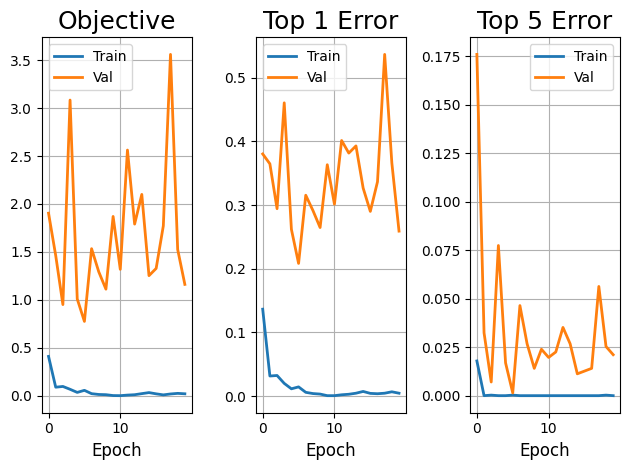

In [10]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3)
ax1.grid()
ax1.plot(loss['train'],linewidth=2)
ax1.plot(loss['val'],linewidth=2)
#ax1.legend(['Train', 'Val'],fontsize=12)
ax1.legend(['Train', 'Val'])
ax1.set_title('Objective', fontsize=18, color='black')
ax1.set_xlabel('Epoch', fontsize=12)

ax2.grid()
ax2.plot(top1err['train'],linewidth=2)
ax2.plot(top1err['val'],linewidth=2)
ax2.legend(['Train', 'Val'])
ax2.set_title('Top 1 Error', fontsize=18, color='black')
ax2.set_xlabel('Epoch', fontsize=12)

ax3.grid()
ax3.plot(top5err['train'],linewidth=2)
ax3.plot(top5err['val'],linewidth=2)
ax3.legend(['Train', 'Val'])
ax3.set_title('Top 5 Error', fontsize=18, color='black')
ax3.set_xlabel('Epoch', fontsize=12)
plt.tight_layout()
plt.show()
# fig.savefig('net-train.pdf')